In [1]:
from pandas import Series, DataFrame

import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('../Data_source/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


해당 데이터셋을 이용해 '고객 세분화 분석'을 진행해 어떤 고객층에 집중하는 것이 좋을지 파악하고자 한다.

일단 데이터셋 칼럼을 파악해보면 다음과 같다.
- CustomerID: 고객 각각에게 부여된 unique ID
- Gender: 성별
- Age: 나이
- Annual Income: 고객의 1년 수입(k$)
- Spending Score(1-100): 고객의 소비 습관 혹은 방식을 근거로 해 마켓에서 부여한 점수

#### 어떤 내용을 추출해볼 수 있을까?

'Spending Score'를 기준으로 고객 segment를 어떻게 진행할 수 있을까?

1. 고객 성별 분포
2. 고객 나이 분포
3. 고객 1년 수입 분포(countplot, hist)
4. 고객 소비 점수 분포(countplot, hist)
5. 요인별 상관관계 파악(연 수입이 높은 고객은 소비 점수도 높을까? 소비 점수가 높은 고객의 나이 분포는 어떠한가? 성별은 어떠한가? 등)
6. 고객 세분화 분석(k-means algorithm)으로 어떻게 분류가 되는지 살펴보기 ==> 세분화된 결과 각 그룹별로 소비 점수 혹은 연 수입 혹은 나이는 어떠한지 비교하기, 비교를 통해 마케팅으로 어떻게 활용할 수 있을지 생각해보기

In [3]:
# 컬럼 타입 확인 및 변경

df['CustomerID'] = df['CustomerID'].astype('str')
df['Gender'] = df['Gender'].astype('object')
df.dtypes

CustomerID                object
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [4]:
# 컬럼명 변경

df=df.rename(columns={'Annual Income (k$)':'annualIncome', 'Spending Score (1-100)':'spendingScore'})
df

,CustomerID,Gender,Age,annualIncome,spendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [5]:
# 누락값 파악
df.isnull().value_counts()

# 해당 데이터셋에는 누락값이 없음

CustomerID  Gender  Age    annualIncome  spendingScore
False       False   False  False         False            200
dtype: int64

In [6]:
# 1. 고객 성별 분포

dist_gender = df['Gender'].value_counts()
print(dist_gender)
rate_gender = df['Gender'].value_counts(normalize=True)
rate_gender

Female    112
Male       88
Name: Gender, dtype: int64


Female    0.56
Male      0.44
Name: Gender, dtype: float64

총 200명의 고객 중 여성이 112명, 남성이 88명으로 구성되어 있다. 

In [7]:
# 2. 고객 나이 요약 통계

stat_age = df['Age'].describe()
round(stat_age,2)

count    200.00
mean      38.85
std       13.97
min       18.00
25%       28.75
50%       36.00
75%       49.00
max       70.00
Name: Age, dtype: float64

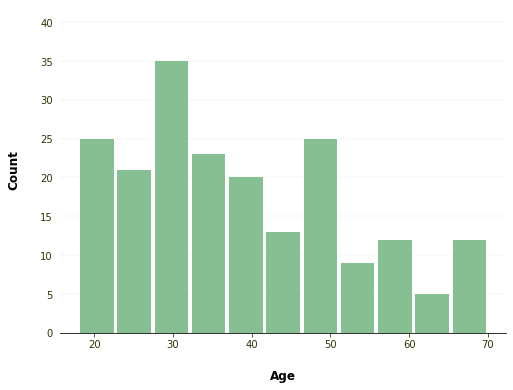

In [8]:
# 2. 고객 나이 분포

dist_age = df.hist(column='Age', bins=11, grid=False, figsize=(8,6), color='#86bf91', zorder=2, rwidth=0.9)
# zorder는 앞으로, 뒤로 순서(중요성)를 정하는 파라미터

dist_age = dist_age[0]
for x in dist_age:
    
    # plot 축 지우기
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    
    # 축의 값 설정
    x.tick_params(axis='both', which='both', left=False, colors='#283906')
    
    # 수평선 그리기
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color="#eeeeee", zorder=1)
        
    # 타이틀 설정
    x.set_title("")
    
    # x축 라벨 설정
    x.set_xlabel("Age", labelpad=20, weight='bold', size=12)
    
    # y축 라벨 설정
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)



200명의 고객 나이를 11개의 군집으로 나눴고, 18-70세까의 나이로 구성되어 있다. 위의 히스토그램을 살펴보면,
- 30세를 전후로 한 그룹에 가장 많은 고객들이 포함되어 있고, 이후로 20세 전후, 40대 후반부터 50대 초반까지의 그룹으로 이어진다.
- 20대 ~ 30대의 고객군이 가장 많은 비중을 차지하고 있음을 알 수 있다.
- 60대의 고객군이 가장 수가 적다.

** 11개의 군집으로 나눈 이유는 10살을 기준으로 각 세대를 나눴을 때 10대 ~ 60대까지 총 6개의 그룹으로 나눌 수 있는데, 10대의 경우 18, 19살만 있어 한 그룹으로 보고 나머지 5개 세대의 그룹은 2그룹씩 나눴다. 그래서 총 11개의 군집으로 히스토그램을 만들었다.

In [9]:
# 3. 고객 1년 수입 요약통계

stat_income = df['annualIncome'].describe()
round(stat_income, 2)

count    200.00
mean      60.56
std       26.26
min       15.00
25%       41.50
50%       61.50
75%       78.00
max      137.00
Name: annualIncome, dtype: float64

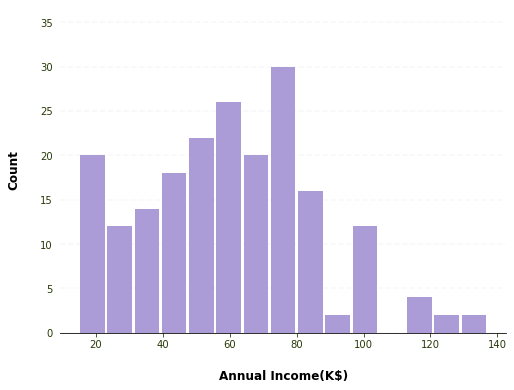

In [10]:
# 3. 고객 연 수입(k$) 분포

dist_income = df.hist(column='annualIncome', bins=15, grid=False, figsize=(8,6), color='#AB9BD7', zorder=2, rwidth=0.9)
# zorder는 앞으로, 뒤로 순서(중요성)를 정하는 파라미터

dist_income = dist_income[0]
for x in dist_income:
    
    # plot 축 지우기
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    
    # 축의 값 설정
    x.tick_params(axis='both', which='both', left=False, colors='#283906')
    
    # 수평선 그리기
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color="#eeeeee", zorder=1)
        
    # 타이틀 설정
    x.set_title("")
    
    # x축 라벨 설정
    x.set_xlabel("Annual Income(K$)", labelpad=20, weight='bold', size=12)
    
    # y축 라벨 설정
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

In [11]:
# 4. 고객 소비 점수 요약 통계

stat_score = df['spendingScore'].describe()
round(stat_score, 2)

count    200.00
mean      50.20
std       25.82
min        1.00
25%       34.75
50%       50.00
75%       73.00
max       99.00
Name: spendingScore, dtype: float64

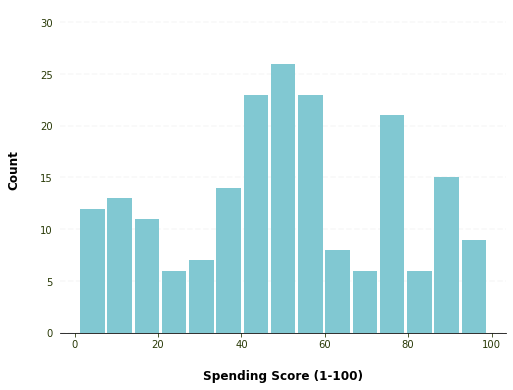

In [12]:
# 4. 고객 소비 점수 분포

dist_score = df.hist(column='spendingScore', bins=15, grid=False, figsize=(8,6), color='#81C8D2', zorder=2, rwidth=0.9)
# zorder는 앞으로, 뒤로 순서(중요성)를 정하는 파라미터

dist_score = dist_score[0]
for x in dist_score:
    
    # plot 축 지우기
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    
    # 축의 값 설정
    x.tick_params(axis='both', which='both', left=False, colors='#283906')
    
    # 수평선 그리기
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color="#eeeeee", zorder=1)
        
    # 타이틀 설정
    x.set_title("")
    
    # x축 라벨 설정
    x.set_xlabel("Spending Score (1-100)", labelpad=20, weight='bold', size=12)
    
    # y축 라벨 설정
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

                 Gender       Age  annualIncome  spendingScore
Gender         1.000000 -0.060867     -0.056410       0.058109
Age           -0.060867  1.000000     -0.012398      -0.327227
annualIncome  -0.056410 -0.012398      1.000000       0.009903
spendingScore  0.058109 -0.327227      0.009903       1.000000


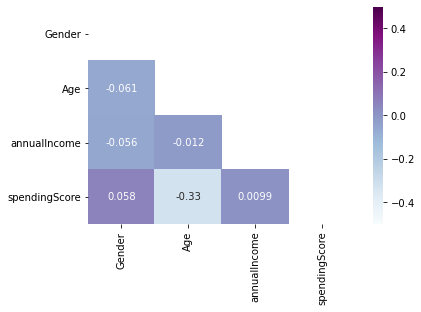

In [13]:
# 5. 요인별 상관관계 파악(연 수입이 높은 고객은 소비 점수도 높을까? 소비 점수가 높은 고객의 나이 분포는 어떠한가? 성별은 어떠한가? 등)

# Gender 컬럼 값 숫자로 치환
corr_df = df.replace({'Gender': {'Male': 0, 'Female': 1}})
corr_df.head()

corr_table = corr_df.corr()
print(corr_table)

# corr heatmap
matrix = np.triu(corr_table)
heatmap = sns.heatmap(corr_table, annot = True, fmt='.2g', center=0, vmin=-.5, vmax=.5, cmap='BuPu', mask=matrix)
# annot: 값 표시 여부, fmt: 값의 자릿수 기준('.1g', '.2g'..), center: bar의 센터 기준 값, vmin: bar의 최저 기준값, vmax: bar의 최고 기준값,
# cmap: 히트맵 컬러, mask: 히트맵을 삼각형 모양으로 변형하는(with np.triu)

요인별 상관관계를 파악해 보면, 
- 'Age'-'spendingScore'의 관계가 가장 유의미해 보인다. 두 요인은 약한 음의 상관관계를 갖고 있으며, 나이가 많다고 해서 '소비 점수'가 높지 않고 나이가 적다고 해서 '소비 점수가' 낮지 않음을 추측해 볼 수 있다. 
- 'annualIncome'-'spendingScore'의 관계는 거의 0에 가까우며, 이는 두 요인이 독립적, 서로 상관관계가 거의 없다는 것을 추측해 볼 수 있다.
- 'Gender'-'spendingScore'의 관계 역시 -0.058로 0에 가까우며, 이 역시 두 요인이 독립적인 관계에 가깝다고 볼 수 있다.

결과적으로 'spendingScore'는 'Age'와 음의 상관관계를 보여주고 있음을 알 수 있다.

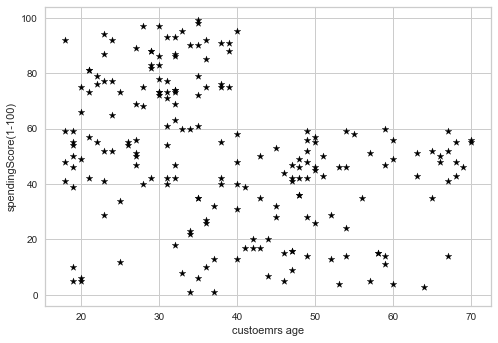

In [30]:
# 6. 고객 segment 분석: k-clustering
# 약한 음의 상관관계를 갖고 있는 Age, spendingScore 두 개의 변수를 가지고 먼저 어떻게 분포해 있는지 살펴보자.

# 'Age', 'spendingScore'만을 빼서 numpy로 전환
X = df[['Age', 'spendingScore']].to_numpy()

# visualize
plt.scatter(X[:,0], X[:,1], c='black', marker = '*')
plt.xlabel('custoemrs age')
plt.ylabel('spendingScore(1-100)')
plt.show()


200명의 나이와 소비 점수(1-100)가 점으로 찍혔고, 이제 n개의 군집화를 통해 고객 세그먼트를 진행해 보겠다.

In [32]:
# clustering 모델 만들기

model = KMeans(n_clusters = 5, init = 'random', n_init = 1, max_iter = 10, random_state = 20).fit(X)

c0, c1, c2, c3, c4 = model.cluster_centers_

print(c0)
print(c1)
print(c2)
print(c3)
print(c4)

# 하나의 배열로 출력하려면
# print(model.cluster_centers_)

model.labels_

[55.9787234 48.5106383]
[43.5        14.30434783]
[29.12903226 41.96774194]
[27.97058824 64.38235294]
[30.57142857 86.        ]


array([2, 4, 1, 4, 2, 3, 1, 4, 1, 3, 1, 4, 1, 4, 1, 4, 2, 3, 1, 4, 2, 3,
       1, 3, 1, 4, 1, 3, 2, 4, 1, 3, 1, 4, 1, 4, 1, 3, 1, 3, 0, 4, 0, 3,
       1, 3, 0, 2, 2, 2, 0, 3, 3, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3,
       0, 0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 3, 0, 0, 3, 0, 0, 3,
       3, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 3, 0, 2, 0, 0, 0, 0,
       0, 3, 2, 2, 2, 2, 0, 0, 0, 0, 3, 2, 3, 4, 2, 4, 2, 4, 1, 4, 1, 4,
       2, 3, 1, 4, 1, 3, 1, 3, 1, 4, 2, 4, 1, 4, 0, 3, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 3, 0, 4, 1, 4, 1, 4, 1, 4, 1, 3, 1, 3, 1, 4, 1, 4,
       1, 3, 1, 4, 2, 4, 1, 4, 2, 4, 1, 3, 1, 4, 1, 3, 1, 4, 1, 4, 1, 3,
       1, 4], dtype=int32)

처음에는 5개로 잡고 클러스터링을 진행하였습니다.

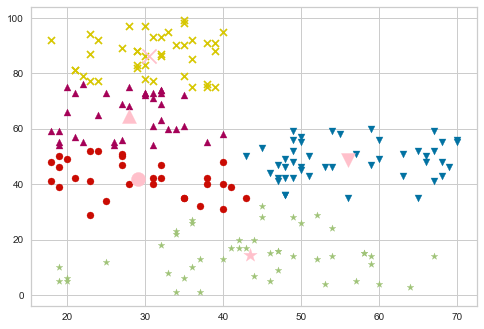

In [34]:
plt.scatter(X[model.labels_ == 0,0], X[model.labels_ == 0,1], marker = 'v')
plt.scatter(X[model.labels_ == 1,0], X[model.labels_ == 1,1], marker = '*')
plt.scatter(X[model.labels_ == 2,0], X[model.labels_ == 2,1], marker = 'o')
plt.scatter(X[model.labels_ == 3,0], X[model.labels_ == 3,1], marker = '^')
plt.scatter(X[model.labels_ == 4,0], X[model.labels_ == 4,1], marker = 'x')


plt.scatter(c0[0], c0[1], marker = 'v', s = 200, facecolor = 'pink')
plt.scatter(c1[0], c1[1], marker = '*', s = 200, facecolor = 'pink')
plt.scatter(c2[0], c2[1], marker = 'o', s = 200, facecolor = 'pink')
plt.scatter(c3[0], c3[1], marker = '^', s = 200, facecolor = 'pink')
plt.scatter(c4[0], c4[1], marker = 'x', s = 200, facecolor = 'pink')


다섯 개의 랜덤한 centroids를 찍고 각 centroid를 기준으로 클러스터링을 한 번 시행했을 때의 결과입니다.
5개로 나뉘어 있기는 하지만 이게 최적인지는 알 수 없습니다.

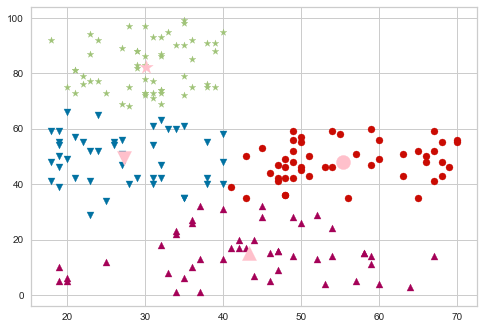

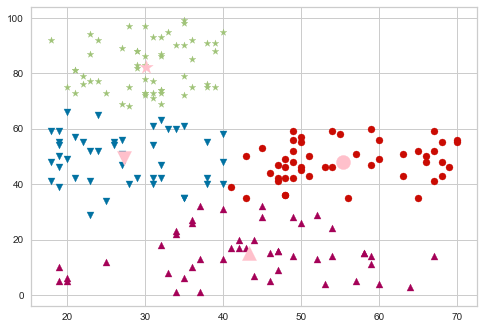

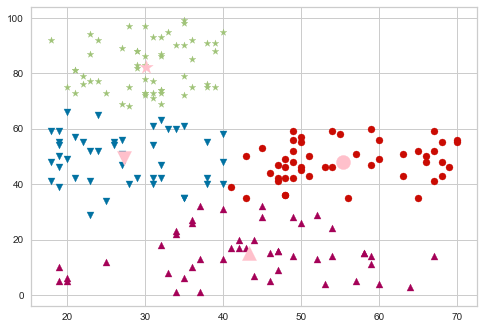

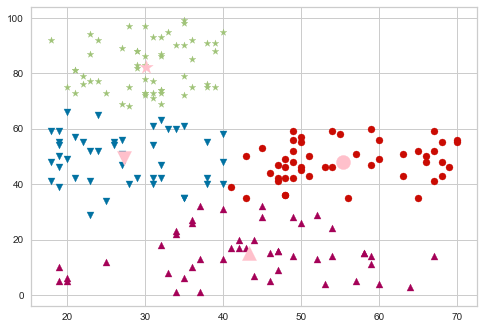

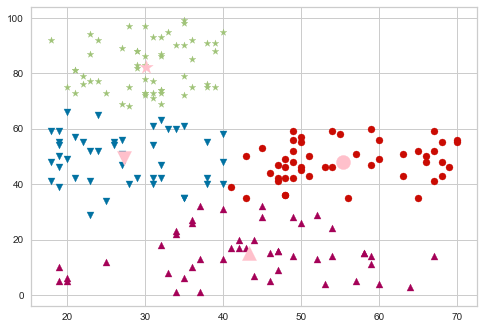

In [35]:
# 함수 선언해서 군집 변화 보기

def model_cluster(n):
    model = KMeans(n_clusters = 4, init = 'random', n_init = 1, max_iter = 10, random_state = 10).fit(X)
    c0, c1, c2, c3 = model.cluster_centers_
    
    plt.scatter(X[model.labels_ == 0,0], X[model.labels_ == 0,1], marker = 'v')
    plt.scatter(X[model.labels_ == 1,0], X[model.labels_ == 1,1], marker = '*')
    plt.scatter(X[model.labels_ == 2,0], X[model.labels_ == 2,1], marker = 'o')
    plt.scatter(X[model.labels_ == 3,0], X[model.labels_ == 3,1], marker = '^')

    plt.scatter(c0[0], c0[1], marker = 'v', s = 200, facecolor = 'pink')
    plt.scatter(c1[0], c1[1], marker = '*', s = 200, facecolor = 'pink')
    plt.scatter(c2[0], c2[1], marker = 'o', s = 200, facecolor = 'pink')
    plt.scatter(c3[0], c3[1], marker = '^', s = 200, facecolor = 'pink')
    
    plt.pause(1)
    plt.show()
    
for i in range(5):
    model_cluster(i)
    

K를 4, 5, 6으로 시행해 보며 최적의 클러스터를 찾기 위해 for 루프를 실행했지만 큰 차이는 없었습니다.

In [38]:
# 실루엣 스코어로 클러스터 평가하기

print(silhouette_score(X, model.labels_))

0.4098245236841793


클러스터링을 평가하는 하나의 방법인 '실루엣 스코어'로 해당 클러스터링을 평가해 보았고, (-1, 1)까지의 값이 나옵니다.
값이 1에 가까우면 클러스터끼리 서로 관련이 없다(잘 분류가 됐다)라고 볼 수 있고, -1에 가까울수록 클러스터가 서로 중첩되어 있다(분류가 제대로 되지 않았다)라고 봅니다. 해당 점수는 K=5인 경우의 실루엣 스코어 입니다. 0.41로 어느정도 분류가 됐다고 봅니다.
하지만 어떤 K가 가장 최적인지 궁금해졌습니다. 그래서 아래의 방법을 이용해 최적의 K를 찾아보았습니다.

In [39]:
# yellowbrick lib install
# conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer

yellowbrick 라이브러리의 elbow method를 이용해 실루엣 스코어가 가장 높은 K를 찾습니다.

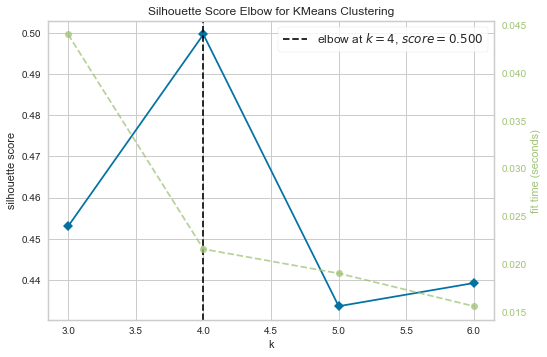

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [41]:
Model = KMeans()
visualizer = KElbowVisualizer(Model, k=(3, 7), metric='silhouette', timings=True)  # K 값을 3~7로 잡고 실루엣 스코어 점수로 

visualizer.fit(X)
visualizer.show()

해당 그래프를 보면 K가 4일 때 0.5로 가장 높은 실루엣 스코어를 갖습니다. 그리고 3일 때가 5일 때보다 오히려 더 높은 스코어 입니다. 
또한 각 클러스터링을 진행했을 때 걸린 시간을 보면 3일 때가 가장 오래 걸리고 갈수록 작아집니다.
이를 통해 K=4일 때가 가장 최적의 클러스터링 결과를 가져온다고 볼 수 있습니다.